In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import mplfinance as mpf
import matplotlib as mpl# 用于设置曲线参数
from cycler import cycler# 用于定制线条颜色

In [2]:
#数据清洗：丢弃行，或用上一行的值填充
def data_wash(dataset,keepTime=False):
    if keepTime:
        dataset.fillna(axis=1,method='ffill')
    else:
        dataset.dropna()
    return dataset

In [3]:
def import_csv(stock_code):
    #time设为index的同时是否保留时间列
    df = pd.read_csv('stock_daily/'+stock_code + '.csv')
    #清洗数据
    df=data_wash(df,keepTime=False)
    df.rename(
            columns={
            'trade_date': 'Date', 'open': 'Open', 
            'high': 'High', 'low': 'Low', 
            'close': 'Close', 'vol': 'Volume'}, 
            inplace=True)
    df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')    
    df.set_index(df['Date'], inplace=True)
    return df

In [361]:
def draw_Kline(df,period,symbol):
    # 设置基本参数
    # type:绘制图形的类型，有candle, renko, ohlc, line等
    # 此处选择candle,即K线图
    # mav(moving average):均线类型,此处设置7,30,60日线
    # volume:布尔类型，设置是否显示成交量，默认False
    # title:设置标题
    # y_label:设置纵轴主标题
    # y_label_lower:设置成交量图一栏的标题
    # figratio:设置图形纵横比
    # figscale:设置图形尺寸(数值越大图像质量越高)
    kwargs = dict(
        type='candle', 
        mav=(7, 30, 60), 
        volume=True, 
        title='\nA_stock %s candle_line' % (symbol),    
        ylabel='OHLC Candles', 
        ylabel_lower='Shares\nTraded Volume', 
        figratio=(15, 10), 
        figscale=2)

    # 设置marketcolors
    # up:设置K线线柱颜色，up意为收盘价大于等于开盘价
    # down:与up相反，这样设置与国内K线颜色标准相符
    # edge:K线线柱边缘颜色(i代表继承自up和down的颜色)，下同。详见官方文档)
    # wick:灯芯(上下影线)颜色
    # volume:成交量直方图的颜色
    # inherit:是否继承，选填
    mc = mpf.make_marketcolors(
        up='red', 
        down='green', 
        edge='i', 
        wick='i', 
        volume='in', 
        inherit=True)

    # 设置图形风格
    # gridaxis:设置网格线位置
    # gridstyle:设置网格线线型
    # y_on_right:设置y轴位置是否在右
    s = mpf.make_mpf_style(
        gridaxis='both', 
        gridstyle='-.', 
        y_on_right=False, 
        marketcolors=mc)

    # 设置均线颜色，配色表可见下图
    # 建议设置较深的颜色且与红色、绿色形成对比
    # 此处设置七条均线的颜色，也可应用默认设置
    mpl.rcParams['axes.prop_cycle'] = cycler(
        color=['dodgerblue', 'deeppink', 
        'navy', 'teal', 'maroon', 'darkorange', 
        'indigo'])
    
    # 设置线宽
    mpl.rcParams['lines.linewidth'] = .5

    # 图形绘制
    # show_nontrading:是否显示非交易日，默认False
    # savefig:导出图片，填写文件名及后缀
    mpf.plot(df, 
        **kwargs, 
        style=s, 
        show_nontrading=False,)
    mpf.plot(df, 
        **kwargs, 
        style=s, 
        show_nontrading=False,
        savefig='A_stock-%s %s_candle_line'
        %(symbol, period) + '.jpg')
    plt.show()

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import Dataset,DataLoader
import math
import numpy as np
import os

In [404]:
#读取数据切割数据集并保存
TRAIN_WEIGHT=0.9
SEQ_LEN=99
LEARNING_RATE=0.00001
BATCH_SIZE=4
#train_size=int(TRAIN_WEIGHT*(data.shape[0]))
train_path="stock_daily/stock_train.csv"
test_path="stock_daily/stock_test.csv"
#Train_data=data[:train_size+SEQ_LEN]
#Test_data=data[train_size-SEQ_LEN:]
#Train_data.to_csv(train_path,sep=',',index=False,header=False)
#Test_data.to_csv(test_path,sep=',',index=False,header=False)

In [321]:
mean_list=[]
std_list=[]

In [358]:
#完成数据集类
class Stock_Data(Dataset):
    def __init__(self,train=True,transform=None):        
        if train==True:
            train_path="stock_daily/stock_train.csv"
            with open(train_path) as f:
                self.data = np.loadtxt(f,delimiter = ",")
                #可以注释
                #addi=np.zeros((self.data.shape[0],1))
                #self.data=np.concatenate((self.data,addi),axis=1)
                self.data=self.data[:,0:8]
            for i in range(len(self.data[0])):
                mean_list.append(np.mean(self.data[:,i]))
                std_list.append(np.std(self.data[:,i]))
                self.data[:,i]=(self.data[:,i]-np.mean(self.data[:,i]))/(np.std(self.data[:,i])+1e-8)
            self.value=torch.rand(self.data.shape[0]-SEQ_LEN,SEQ_LEN,self.data.shape[1])
            self.label=torch.rand(self.data.shape[0]-SEQ_LEN,1)
            for i in range(self.data.shape[0]-SEQ_LEN):                  
                self.value[i,:,:]=torch.from_numpy(self.data[i:i+SEQ_LEN,:].reshape(SEQ_LEN,self.data.shape[1]))    
                self.label[i,:]=self.data[i+SEQ_LEN,0]
            self.data=self.value
        else:
            test_path="stock_daily/stock_test.csv"
            with open(test_path) as f:
                self.data = np.loadtxt(f,delimiter = ",")
                #addi=np.zeros((self.data.shape[0],1))
                #self.data=np.concatenate((self.data,addi),axis=1)
                self.data=self.data[:,0:8]
            for i in range(len(self.data[0])):
                self.data[:,i]=(self.data[:,i]-mean_list[i])/(std_list[i]+1e-8)
            self.value=torch.rand(self.data.shape[0]-SEQ_LEN,SEQ_LEN,self.data.shape[1])
            self.label=torch.rand(self.data.shape[0]-SEQ_LEN,1)
            for i in range(self.data.shape[0]-SEQ_LEN):                  
                self.value[i,:,:]=torch.from_numpy(self.data[i:i+SEQ_LEN,:].reshape(SEQ_LEN,self.data.shape[1]))    
                self.label[i,:]=self.data[i+SEQ_LEN,0]
            self.data=self.value
    def __getitem__(self,index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data[:,0])

In [388]:
stock_train=Stock_Data(train=True)
stock_test=Stock_Data(train=False)

In [390]:
class LSTM(nn.Module):
    def __init__(self,dimension):
        super(LSTM,self).__init__()
        self.lstm=nn.LSTM(input_size=dimension,hidden_size=128,num_layers=3,batch_first=True)
        self.linear1=nn.Linear(in_features=128,out_features=16)
        self.linear2=nn.Linear(16,1)
    def forward(self,x):
        out,_=self.lstm(x)
        x=out[:,-1,:]        
        x=self.linear1(x)
        x=self.linear2(x)
        return x

In [391]:
#传入tensor进行位置编码
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=SEQ_LEN):
        super(PositionalEncoding,self).__init__()
        #序列长度，dimension d_model
        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len,dtype=torch.float).unsqueeze(1)
        div_term=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model))
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)
        pe=pe.unsqueeze(0).transpose(0,1)
        self.register_buffer('pe',pe)
        
    def forward(self,x):
        return x+self.pe[:x.size(0),:]

In [392]:
class TransAm(nn.Module):
    def __init__(self,feature_size=8,num_layers=6,dropout=0.1):
        super(TransAm,self).__init__()
        self.model_type='Transformer'
        self.src_mask=None
        self.pos_encoder=PositionalEncoding(feature_size)
        self.encoder_layer=nn.TransformerEncoderLayer(d_model=feature_size,nhead=8,dropout=dropout)
        self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
        #全连接层代替decoder
        self.decoder=nn.Linear(feature_size,1)
        self.linear1=nn.Linear(SEQ_LEN,1)
        self.init_weights()
        self.src_key_padding_mask=None
    
    def init_weights(self):
        initrange=0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange,initrange)
        
    def forward(self,src,seq_len=SEQ_LEN):       
        src=self.pos_encoder(src)
        #print(src)
        #print(self.src_mask)
        #print(self.src_key_padding_mask)
        #output=self.transformer_encoder(src,self.src_mask,self.src_key_padding_mask)
        output=self.transformer_encoder(src)
        output=self.decoder(output)
        output=np.squeeze(output)
        output=self.linear1(output)
        return output

In [394]:
def train(epoch):    
    model.train()
    global loss_list
    global iteration
    dataloader=DataLoader(dataset=stock_train,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    for i,(data,label) in enumerate(dataloader):
        iteration=iteration+1
        data,label = data.to(device),label.to(device)
        optimizer.zero_grad()
        output=model.forward(data)
        loss=criterion(output,label)
        loss.backward()        
        optimizer.step()
        if i%20==0:
            loss_list.append(loss.item())
            print("epoch=",epoch,"iteration=",iteration,"loss=",loss.item())
        if iteration%1000==0:
            torch.save(model.state_dict,"./000001SZ/000001SZ_"+str(iteration)+"_Model.pkl")
            torch.save(optimizer.state_dict,"./000001SZ/000001SZ_"+str(iteration)+"_Optimizer.pkl")

In [395]:
def test():
    model.eval()
    global accuracy_list
    global predict_list
    dataloader=DataLoader(dataset=stock_test,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    for i,(data,label) in enumerate(dataloader):
        with torch.no_grad():            
            data,label=data.to(device),label.to(device)
            optimizer.zero_grad()
            predict=model.forward(data)
            predict_list.append(predict)
            loss=criterion(predict,label)
            accuracy_fn=nn.MSELoss()
            accuracy=accuracy_fn(predict,label)
            accuracy_list.append(accuracy.item())
    print("test_data MSELoss:(pred-real)/real=",np.mean(accuracy_list))

In [396]:
def loss_curve(loss_list):
    x=np.linspace(1,len(loss_list),len(loss_list))
    x=20*x
    plt.plot(x,np.array(loss_list),label="train_loss")
    plt.ylabel("MSELoss")
    plt.xlabel("iteration")
    plt.savefig("train_loss.png",dpi=3000)
    plt.show()

In [397]:
def contrast_lines(predict_list):
    real_list=[]
    prediction_list=[]
    dataloader=DataLoader(dataset=stock_test,batch_size=4,shuffle=False,drop_last=True)
    for i,(data,label) in enumerate(dataloader):
        for idx in range(BATCH_SIZE):
            real_list.append(np.array(label[idx]*std_list[0]+mean_list[0]))
    for item in predict_list:
        item=item.to("cpu")
        for idx in range(BATCH_SIZE):
            prediction_list.append(np.array((item[idx]*std_list[0]+mean_list[0])))
    x=np.linspace(1,len(real_list),len(real_list))
    plt.plot(x,np.array(real_list),label="real")
    plt.plot(x,np.array(prediction_list),label="prediction")
    plt.legend()
    plt.savefig("000001SZ_Pre.png",dpi=3000)
    plt.show()

In [401]:
#x维度实例化模型
model=LSTM(dimension=8)
#model=TransAm(feature_size=8)
if os.path.exists("./000001SZ/LSTM_"+str(1000)+"_Model.pkl"):
    model.load_state_dict(torch.load("./000001SZ/LSTM_"+str(1000)+"_Model.pkl"))
model=model.to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE)
if os.path.exists("./000001SZ/LSTM_"+str(1000)+"_Optimizer.pkl"):
    optimizer.load_state_dict(torch.load("./000001SZ/LSTM_"+str(1000)+"_Optimizer.pkl"))

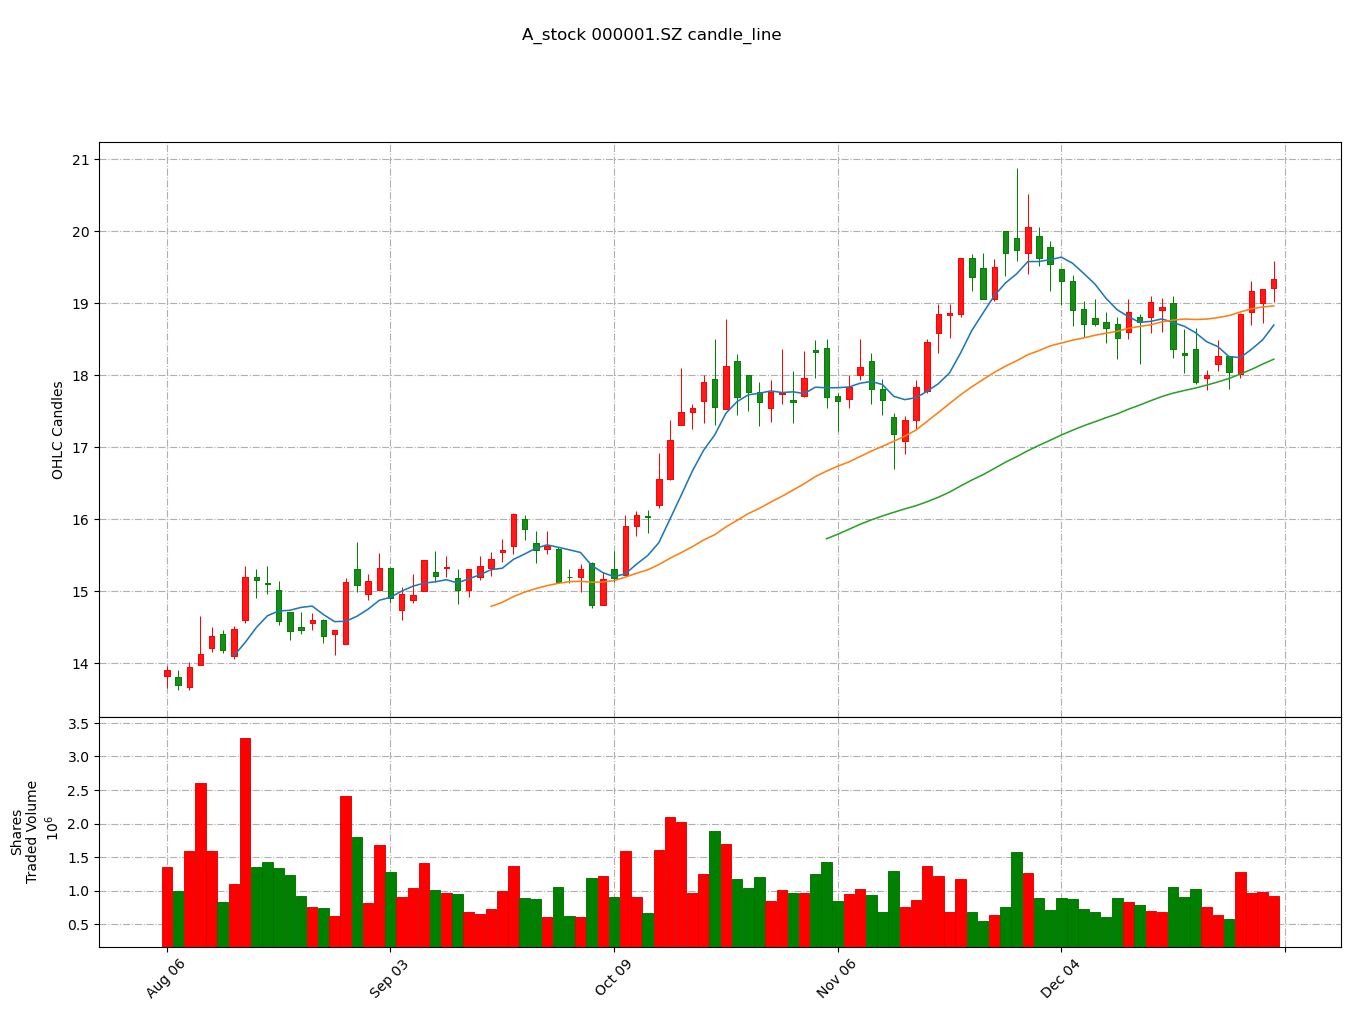

epoch= 0 iteration= 1 loss= 0.15698859095573425
epoch= 0 iteration= 21 loss= 0.8543320894241333
epoch= 0 iteration= 41 loss= 0.6953946352005005
epoch= 0 iteration= 61 loss= 0.7722561359405518
epoch= 0 iteration= 81 loss= 0.0027217601891607046
epoch= 0 iteration= 101 loss= 1.5931286811828613
epoch= 0 iteration= 121 loss= 0.059589944779872894
epoch= 0 iteration= 141 loss= 0.31469792127609253
epoch= 0 iteration= 161 loss= 0.17811918258666992
epoch= 0 iteration= 181 loss= 0.2378970831632614
epoch= 0 iteration= 201 loss= 1.744471549987793
epoch= 0 iteration= 221 loss= 4.572668552398682
epoch= 0 iteration= 241 loss= 0.6503688097000122
epoch= 0 iteration= 261 loss= 1.905510663986206
test_data MSELoss:(pred-real)/real= 4.247378857930501
epoch= 1 iteration= 275 loss= 0.1578979790210724
epoch= 1 iteration= 295 loss= 0.8510895371437073
epoch= 1 iteration= 315 loss= 0.6905876398086548
epoch= 1 iteration= 335 loss= 0.7600556015968323
epoch= 1 iteration= 355 loss= 0.0041556465439498425
epoch= 1 iter

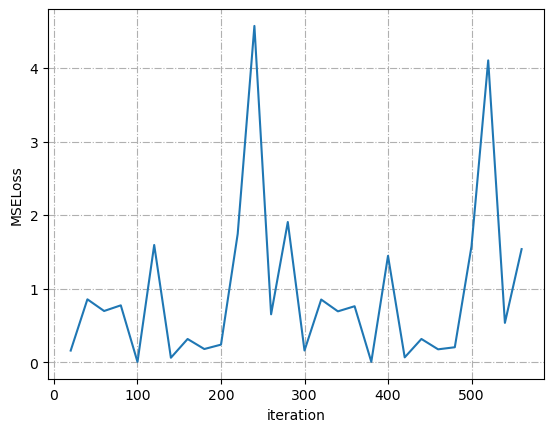

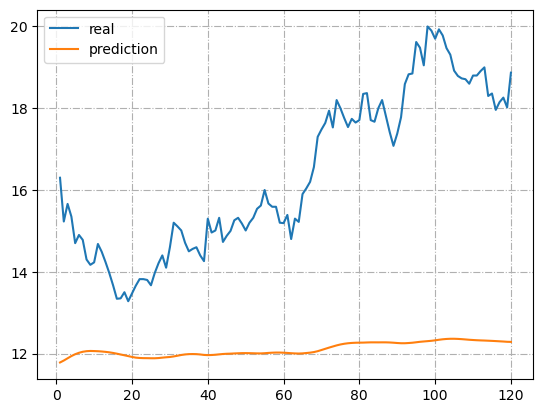

In [402]:
if __name__=="__main__":   
    symbol = '000001.SZ'
    period = 100
    data = import_csv(symbol)
    df_draw=data[-period:]
    draw_Kline(df_draw,period,symbol)
    data.drop(['ts_code','Date'],axis=1,inplace = True)    
    iteration=0
    loss_list=[]
    #开始训练神经网络
    for epoch in range(2):         
        predict_list=[]
        accuracy_list=[]
        train(epoch)
        test()
    #绘制损失函数下降曲线    
    loss_curve(loss_list)
    #绘制测试集pred-real对比曲线
    contrast_lines(predict_list)